# Word2Vec using Tensorflow

Using tensorflow for Word2Vec. Note that the gensim library is better for the word2vec API

In [4]:
import collections
import math
import os
import errno
import random
import zipfile

import tensorflow as tf
# import cupy as np
import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib
from six.moves import xrange

## Downloading the Data

In [5]:
data_dir = "word2vec_data/words"
data_url = "http://mattmahoney.net/dc/text8.zip"

In [6]:
def fetch_words_data(url=data_url, words_data=data_dir):
    # mkdir if dir doesnt exist
    os.makedirs(words_data, exist_ok=True)
    # Path to zip file
    zip_path = os.path.join(words_data, 'words.zip')
    # if !zip file, download it from the data url
    if not os.path.exists(zip_path):
        print("Data not found, downloading from source")
        urllib.request.urlretrieve(url, zip_path)
        print("Download Complete")
    else:
        print("Data Found")
    # Now the zip file is there, get the data from it
    print("Reading the data")
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    print("Reading Complete")
    # Return a list of all the words in the dataSource
    return data.decode('ascii').split()

In [7]:
words = fetch_words_data()
print("Data Retrieved")

Data Found
Reading the data
Reading Complete
Data Retrieved


In [8]:
len(words)

17005207

About 17 Million Words

In [9]:
words[0:50]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the']

In [10]:
for word in words[0:50]:
    print(word, end=" ")

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the 

See that the words are already lower cased and the special symbols are removed

## Now Building a WordCount

In [11]:
from collections import Counter
# Counter(list) will return a dictionary of the count of the items in the list
# Counter(list).most_common(n) will return the count of most common n words in the list

def create_counts(vocab_size=50000):
    vocab = [] + Counter(words).most_common(vocab_size)
    vocab = np.array([word for word,_ in vocab])
    dictionary = {word:code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word,0) for word in words])
    return data, vocab

In [12]:
data, vocabulary = create_counts()

In [13]:
data.shape

(17005207,)

In [14]:
vocabulary.shape

(50000,)

In [15]:
words[0]

'anarchism'

In [16]:
data[0]

5233

Various words in the data will have an index position in the vocabulary

## Creating the Batch Function

In [17]:
# This code is from Tensorflow doc
# When using gensim, all these are taken care of in the background
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

## Creating the Constants

In [18]:
batch_size = 128
embedding_size = 150 # Number of Dimension of the word vector
skip_window = 1 # How many words to consider on the left and the right of the current word
num_skips = 2 # times to resue an input to generate the label
valid_size = 16 # Random set of words to evaluate the similarity on
valid_window = 100
valid_exaples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64
learning_rate = 0.01
vocabulary_size = 50000

## Creating the Placeholders, Variables and Loss Function

In [19]:
tf.reset_default_graph() # Just in case

# Placeholders for the fata
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
valid_dataset = tf.constant(valid_exaples, dtype=tf.int32)

# Random Initial Embeddings
init_embeds = tf.random_uniform(shape=[vocabulary_size, embedding_size], 
                                minval=-1.0, 
                                maxval=1.0)
# Variables
embeddings = tf.Variable(init_embeds)

# Looks up ids in a list of embeding tensors
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Weights and bias init for noise contrastive estimation (nce)
nce_weights = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, embedding_size],
                                              stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros(shape=[vocabulary_size]))

# Loss Function and Optimizer
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, 
                                     biases=nce_biases, 
                                     labels=train_labels,
                                     inputs=embed,
                                     num_sampled=num_sampled, 
                                     num_classes=vocabulary_size))
# loss = tf.reduce_mean(
#     tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
#                    num_sampled, vocabulary_size))
optimizer = tf.train.AdamOptimizer(learning_rate=1.0) # Okay, lets see
trainer = optimizer.minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Cosine Similarity between MiniBatchExamples and all Embeddings

In [20]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [21]:
data_index = 0

## Global Variables Initializer Object

In [22]:
init = tf.global_variables_initializer()

## Creating a Saver to Save the Model

In [23]:
saver = tf.train.Saver()

In [24]:
# Uncomment if running on GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

## TensorFlow Session

Commenting out the tensorflow training session as it takes a long time. Trained once with 5000 epochs and saved it to a tf.train.saver object. Loading from that in the session below.

In [25]:
'''
num_steps = 5000 # usually do it for 200000 steps but my sweet Nvidia GTX 1060 is at home

# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    # Initializing Variables
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs,
                     train_labels: batch_labels}
        _, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step %100 == 0:
            if step >0:
                average_loss /=  1000
            print("Average loss at step ", step, " is ", average_loss)
            average_loss = 0
        final_embeddings = normalized_embeddings.eval()
    saver.save(sess, "./Word2VecModel_inadequate_5000_epochs")
'''
# Skipping this because I have saved the model that I made earlier to file (180MB)

'\nnum_steps = 5000 # usually do it for 200000 steps but my sweet Nvidia GTX 1060 is at home\n\n# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:\nwith tf.Session() as sess:\n    # Initializing Variables\n    sess.run(init)\n    average_loss = 0\n    \n    for step in range(num_steps):\n        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)\n        feed_dict = {train_inputs: batch_inputs,\n                     train_labels: batch_labels}\n        _, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)\n        \n        average_loss += loss_val\n        \n        if step %100 == 0:\n            if step >0:\n                average_loss /=  1000\n            print("Average loss at step ", step, " is ", average_loss)\n            average_loss = 0\n        final_embeddings = normalized_embeddings.eval()\n    saver.save(sess, "./Word2VecModel_inadequate_5000_epochs")\n'

## (Restoring the above Model)

In [26]:
with tf.Session() as sess:
    saver.restore(sess, "./Word2VecModel_inadequate_5000_epochs")
    final_embeddings = normalized_embeddings.eval()
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Word2VecModel_inadequate_5000_epochs


In [27]:
#average_loss/1000
final_embeddings.shape

(50000, 150)

## Visualizing the Result in 2D

In [28]:
from sklearn.manifold import TSNE # Convert 150 dimensional vectors to two for visualization
# t - distributed stochastic neighbor embedding
# It is a tool to visualize high dimensional data
# Dimensionality Reduction Tech

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [29]:
# Only plpot 500 words out of 50000 to make the plot readable
plot_only = 500
low_dim_embeddings = tsne.fit_transform(final_embeddings[:plot_only]) # First 500

In [30]:
[vocabulary[i] for i in range(10)]

['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two']

In [41]:
labels = [vocabulary[i] for i in range(plot_only)]

In [42]:
low_dim_embeddings.shape

(500, 2)

In [45]:
def plot_with_labels(low_dim_embeddings, labels):
    assert low_dim_embeddings.shape[0] >=len(labels)
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x, y = low_dim_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, 
                     xy=(x, y), 
                     xytext=(5,2), 
                     textcoords='offset points', 
                     ha='right', 
                     va='bottom')

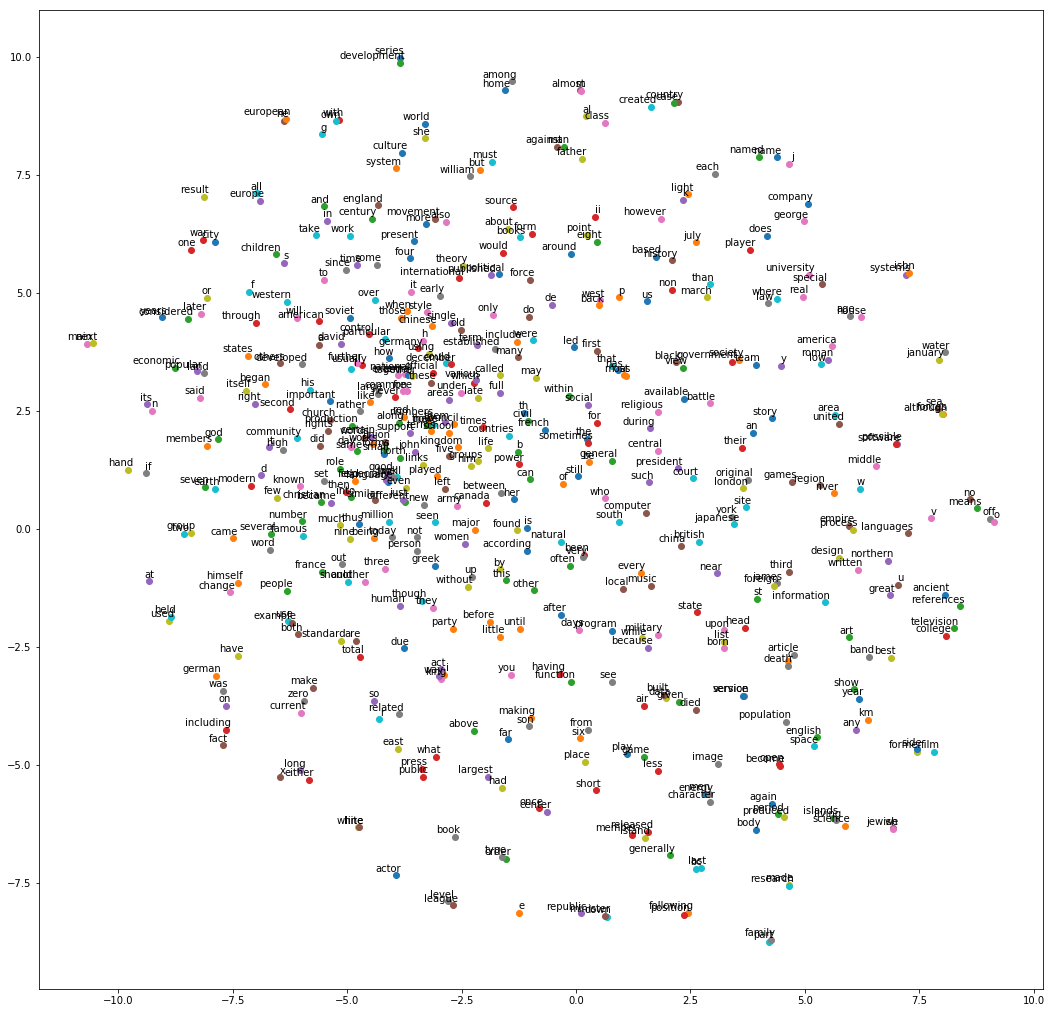

In [46]:
plot_with_labels(low_dim_embeddings, labels) 